# Visualization for Delegation Based Lock

In [1]:
@time using DataFrames, CSV, StatsPlots

bench = @time CSV.read("output/output.csv", DataFrame);


  6.959077 seconds (7.42 M allocations: 432.955 MiB, 5.32% gc time, 4.42% compilation time: 93% of which was recompilation)


  0.999126 seconds (699.54 k allocations: 46.543 MiB, 2.05% gc time, 99.75% compilation time: 73% of which was recompilation)


  2.798883 seconds (5.75 M allocations: 338.398 MiB, 5.11% gc time, 99.46% compilation time: 36% of which was recompilation)


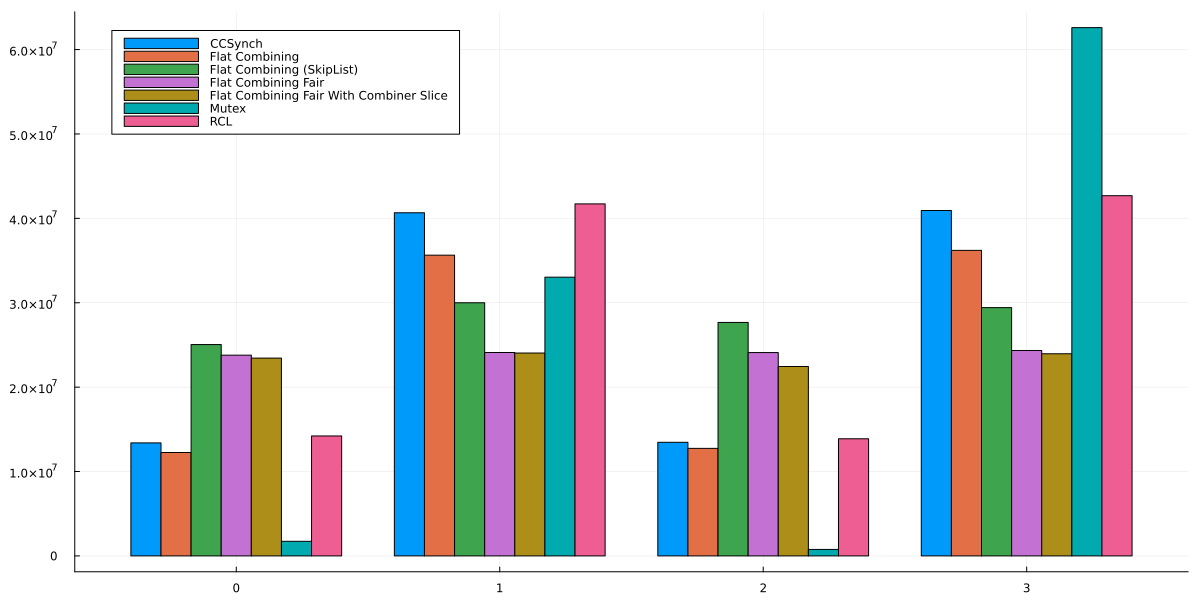

In [2]:
using StatsPlots

loop_comparison = @time @df bench groupedbar(:Id, :LoopCount, group=:Locktype, size=(1200,600))
savefig(loop_comparison, "graphs/loop_comparison.svg")
loop_comparison

In [3]:
bench

Row,Id,CpuId,LoopCount,NumAcquire,HoldTime,CombineTime,Locktype
,Int64,Int64,Int64,Int64,Int64,Int64?,String
1,0,0,25047023,41814,431,2316858625,Flat Combining (SkipList)
2,1,1,29995751,16723,511,1584905447,Flat Combining (SkipList)
3,2,2,27668121,46073,471,1312349440,Flat Combining (SkipList)
4,3,3,29420990,16408,512,1168885792,Flat Combining (SkipList)
5,0,0,12256892,22863,267,6376022792,Flat Combining
6,1,1,35634316,21812,662,132734,Flat Combining
7,2,2,12743761,22195,244,missing,Flat Combining
8,3,3,36209806,21841,663,missing,Flat Combining
9,0,0,23788343,40453,411,1792890267,Flat Combining Fair


  1.796123 seconds (2.36 M allocations: 147.304 MiB, 3.00% gc time, 99.62% compilation time: 14% of which was recompilation)


  0.277777 seconds (266.49 k allocations: 16.599 MiB, 5.93% gc time, 98.22% compilation time)


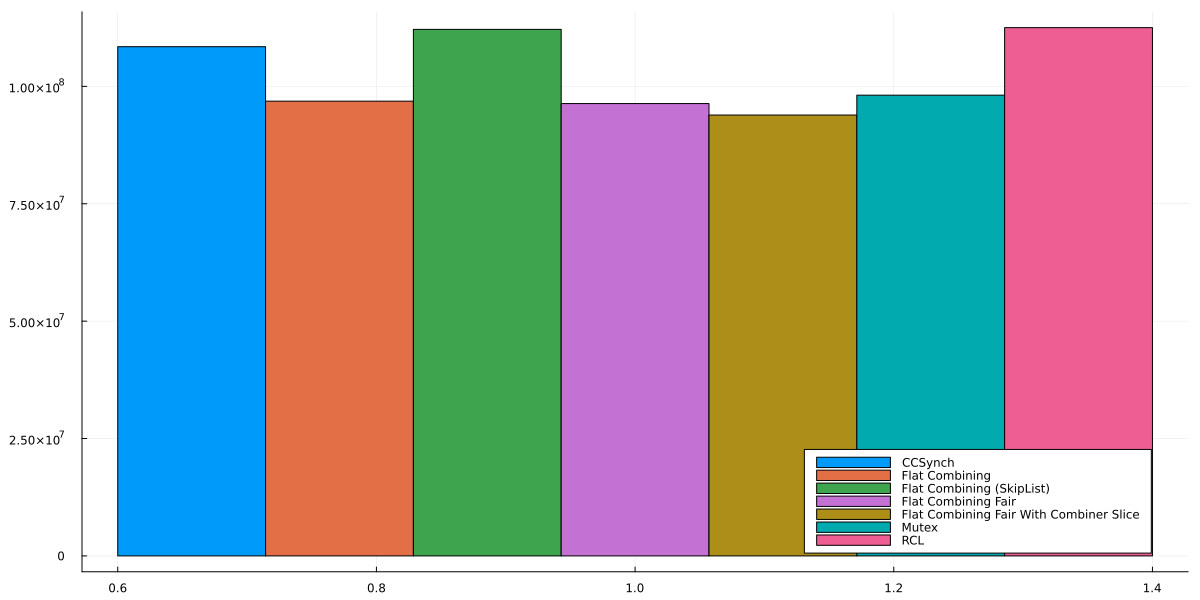

In [4]:
using Tidier

bench_all = @time @chain bench begin
    @group_by(Locktype)
    @summarize(overall_loop = sum(LoopCount))
end

@time @df bench_all groupedbar(:overall_loop, group=:Locktype, size=(1200,600))



  0.712567 seconds (760.12 k allocations: 50.089 MiB, 2.41% gc time, 99.16% compilation time)


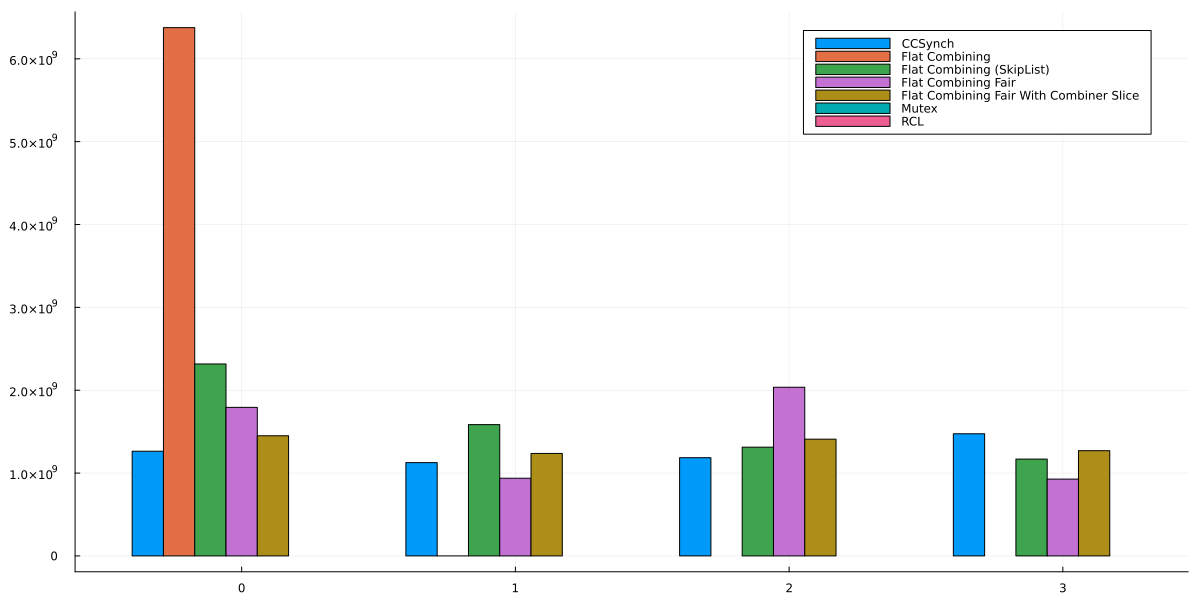

In [5]:
combiner_time_comparison = @time @df bench groupedbar(:Id, :CombineTime, group=:Locktype, size=(1200,600))
savefig("graphs/combiner_time_comparison.svg")
combiner_time_comparison
